<a href="https://www.kaggle.com/code/yaaangzhou/pg-s3-e22-eda-modeling?scriptVersionId=146786730" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created by Yang Zhou**

**[PLAYGROUND S-3,E-22] 📊EDA**

**12 Sep 2023**

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Predict Health Outcomes of Horses</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Playground Series - Season 3, Episode 22</center></p>

***

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Insights and Tricks</center>

+ The column `hosptial number` should be a categorical variable because it represents the numbers of different hospitals.




+ After performing the chi-square test, `lesion_3 Counts` was removed, which resulted in a CV score improvement of approximately 0.02. The metric is F1 score.

+ In column `pain`, different sub-labels appear in the test data and training data. For example, `moderate` appeared in the test data and not in training data. The way I handle this situation is to OneHot encode after merging the test and training data.

+ As long as `lesion_2 Counts` is not 0, outcome is not `Died`. We can do the data preprocessing with the code:
``` python
df['lesion_2'] = df['lesion_2'].apply(lambda x:1 if x>0 else 0)
``` 


+ [bogoconic1](https://www.kaggle.com/competitions/playground-series-s3e22/discussion/438680) noting that with respect to horses, the normal temperature is 37.8. Deviation in both directions (lower or higher) is attributed with a higher chance of falling in the "died" or "euthanised" class. So we can create a new feature with the codes below:
``` python
df["deviation_from_normal_temp"] = df["rectal_temp"].apply(lambda x: abs(x - 37.8))
``` 




+ **Key point**: 
    + Using the original data and performing mode filling==>This makes the public score rise from 0.79268 to 0.82317.
    + Ordinal Encoding works better than OneHot Encoding.==>This makes the public score rise from 0.82317 to 0.82926.
    + Use Label Encoding with caution! It is prepared for target variables, not for input variables. Here is the [source url.](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
    + Using the mode to impute the training data does not perform as well as retaining missing values on the public score. For this reason, we're going to use tree models.

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Version Detail</center>

| Version | Description | Best Public Score |
|---------|-------------|-----------------|
| Version 8 | Add Hist Gradient Boosting | 0.84756 |
| Version 7 | Trying Ordinal Encoding | 0.82926 |
| Version 6 | Add Neural Network | Not improving |
| Version 5 | Add Origin Dataset | 0.82317 |
| Version 4 | Trying Differents Features| Not improving |
| Version 3 | Add Baseline Modeles | Not improving |
| Version 2 | Add ML models | 0.81097 |
| Version 1 | Autogluon Baseline | 0.79878 |



# 0. Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import math
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
#import autogluon as ag

# Models
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier,RandomForestClassifier,ExtraTreesClassifier,VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna

import torch
import torch.nn as nn
import torch.optim as optim
if torch.cuda.is_available():
    device = torch.device("cuda")  
else:
    device = torch.device("cpu")   
    
# Metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Adjusting plot style

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# 1. Load Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e22/sample_submission.csv')
origin = pd.read_csv('/kaggle/input/horse-survival-dataset/horse.csv')

# train["is_generated"] = 1
# test["is_generated"] = 1
# origin["is_generated"] = 0

# Drop column id
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

train_total = pd.concat([train, origin], ignore_index=True)
train_total.drop_duplicates(inplace=True)

total = pd.concat([train_total, test], ignore_index=True)


print('The shape of the train data:', train.shape)
print('The shape of the test data:', test.shape)
print('The shape of the total data:', total.shape)

The shape of the train data: (1235, 28)
The shape of the test data: (824, 27)
The shape of the total data: (2355, 28)


In [4]:
train.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


# 2. EDA


In [5]:
num_var = [column for column in train.columns if train[column].nunique() > 10]

bin_var = [column for column in train.columns if train[column].nunique() == 2]

cat_var = ['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane','capillary_refill_time','pain',
'peristalsis','abdominal_distention','nasogastric_tube','nasogastric_reflux','rectal_exam_feces','abdomen',
'abdomo_appearance','lesion_2','surgery', 'age', 'surgical_lesion', 'lesion_3', 'cp_data']

target = 'outcome'

In [6]:
# cat_var = [column for column in train.columns if train[column].nunique() < 10]
# cat_var.remove('outcome')

In [7]:
train.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
hospital_number,1235.000000,954500.401619,1356403.138940,521399.000000,528800.000000,529777.000000,534145.000000,5305129.000000
rectal_temp,1235.000000,38.202186,0.788668,35.400000,37.800000,38.200000,38.600000,40.800000
pulse,1235.000000,79.574089,29.108638,30.000000,53.000000,76.000000,100.000000,184.000000
respiratory_rate,1235.000000,30.054251,16.452066,8.000000,18.000000,28.000000,36.000000,96.000000
nasogastric_reflux_ph,1235.000000,4.382591,1.937357,1.000000,2.000000,4.500000,6.000000,7.500000
packed_cell_volume,1235.000000,49.602429,10.535800,23.000000,43.000000,48.000000,57.000000,75.000000
total_protein,1235.000000,21.388016,26.676453,3.500000,6.600000,7.500000,9.100000,89.000000
abdomo_protein,1235.000000,3.290931,1.589195,0.100000,2.000000,3.000000,4.300000,10.100000
lesion_1,1235.000000,3832.496356,5436.733774,0.000000,2205.000000,2209.000000,3205.000000,41110.000000
lesion_2,1235.000000,14.612146,193.705735,0.000000,0.000000,0.000000,0.000000,3112.000000


`Hospital number` should appear as a categorical variable, I will handle in feature engineering.

In [8]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum())/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    #sum['skew'] = df.skew().values
    return sum

summary(train_total).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
surgery,object,0,0.000000,2,1531
age,object,0,0.000000,2,1531
hospital_number,int64,0,0.000000,288,1531
rectal_temp,float64,60,0.039190,43,1471
pulse,float64,24,0.015676,52,1507
respiratory_rate,float64,58,0.037884,40,1473
temp_of_extremities,object,95,0.062051,4,1436
peripheral_pulse,object,129,0.084259,4,1402
mucous_membrane,object,68,0.044415,6,1463
capillary_refill_time,object,38,0.024820,3,1493


In [9]:
summary(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
surgery,object,0,0.000000,2,1235
age,object,0,0.000000,2,1235
hospital_number,int64,0,0.000000,255,1235
rectal_temp,float64,0,0.000000,43,1235
pulse,float64,0,0.000000,50,1235
respiratory_rate,float64,0,0.000000,37,1235
temp_of_extremities,object,39,0.031579,4,1196
peripheral_pulse,object,60,0.048583,4,1175
mucous_membrane,object,21,0.017004,6,1214
capillary_refill_time,object,6,0.004858,3,1229


There are more missing cases in `rectal_exam_feces` and `abdomen` columns. In the original data, there are more missing values.

First, i want to look at the distribution of categorical features. Include the target.

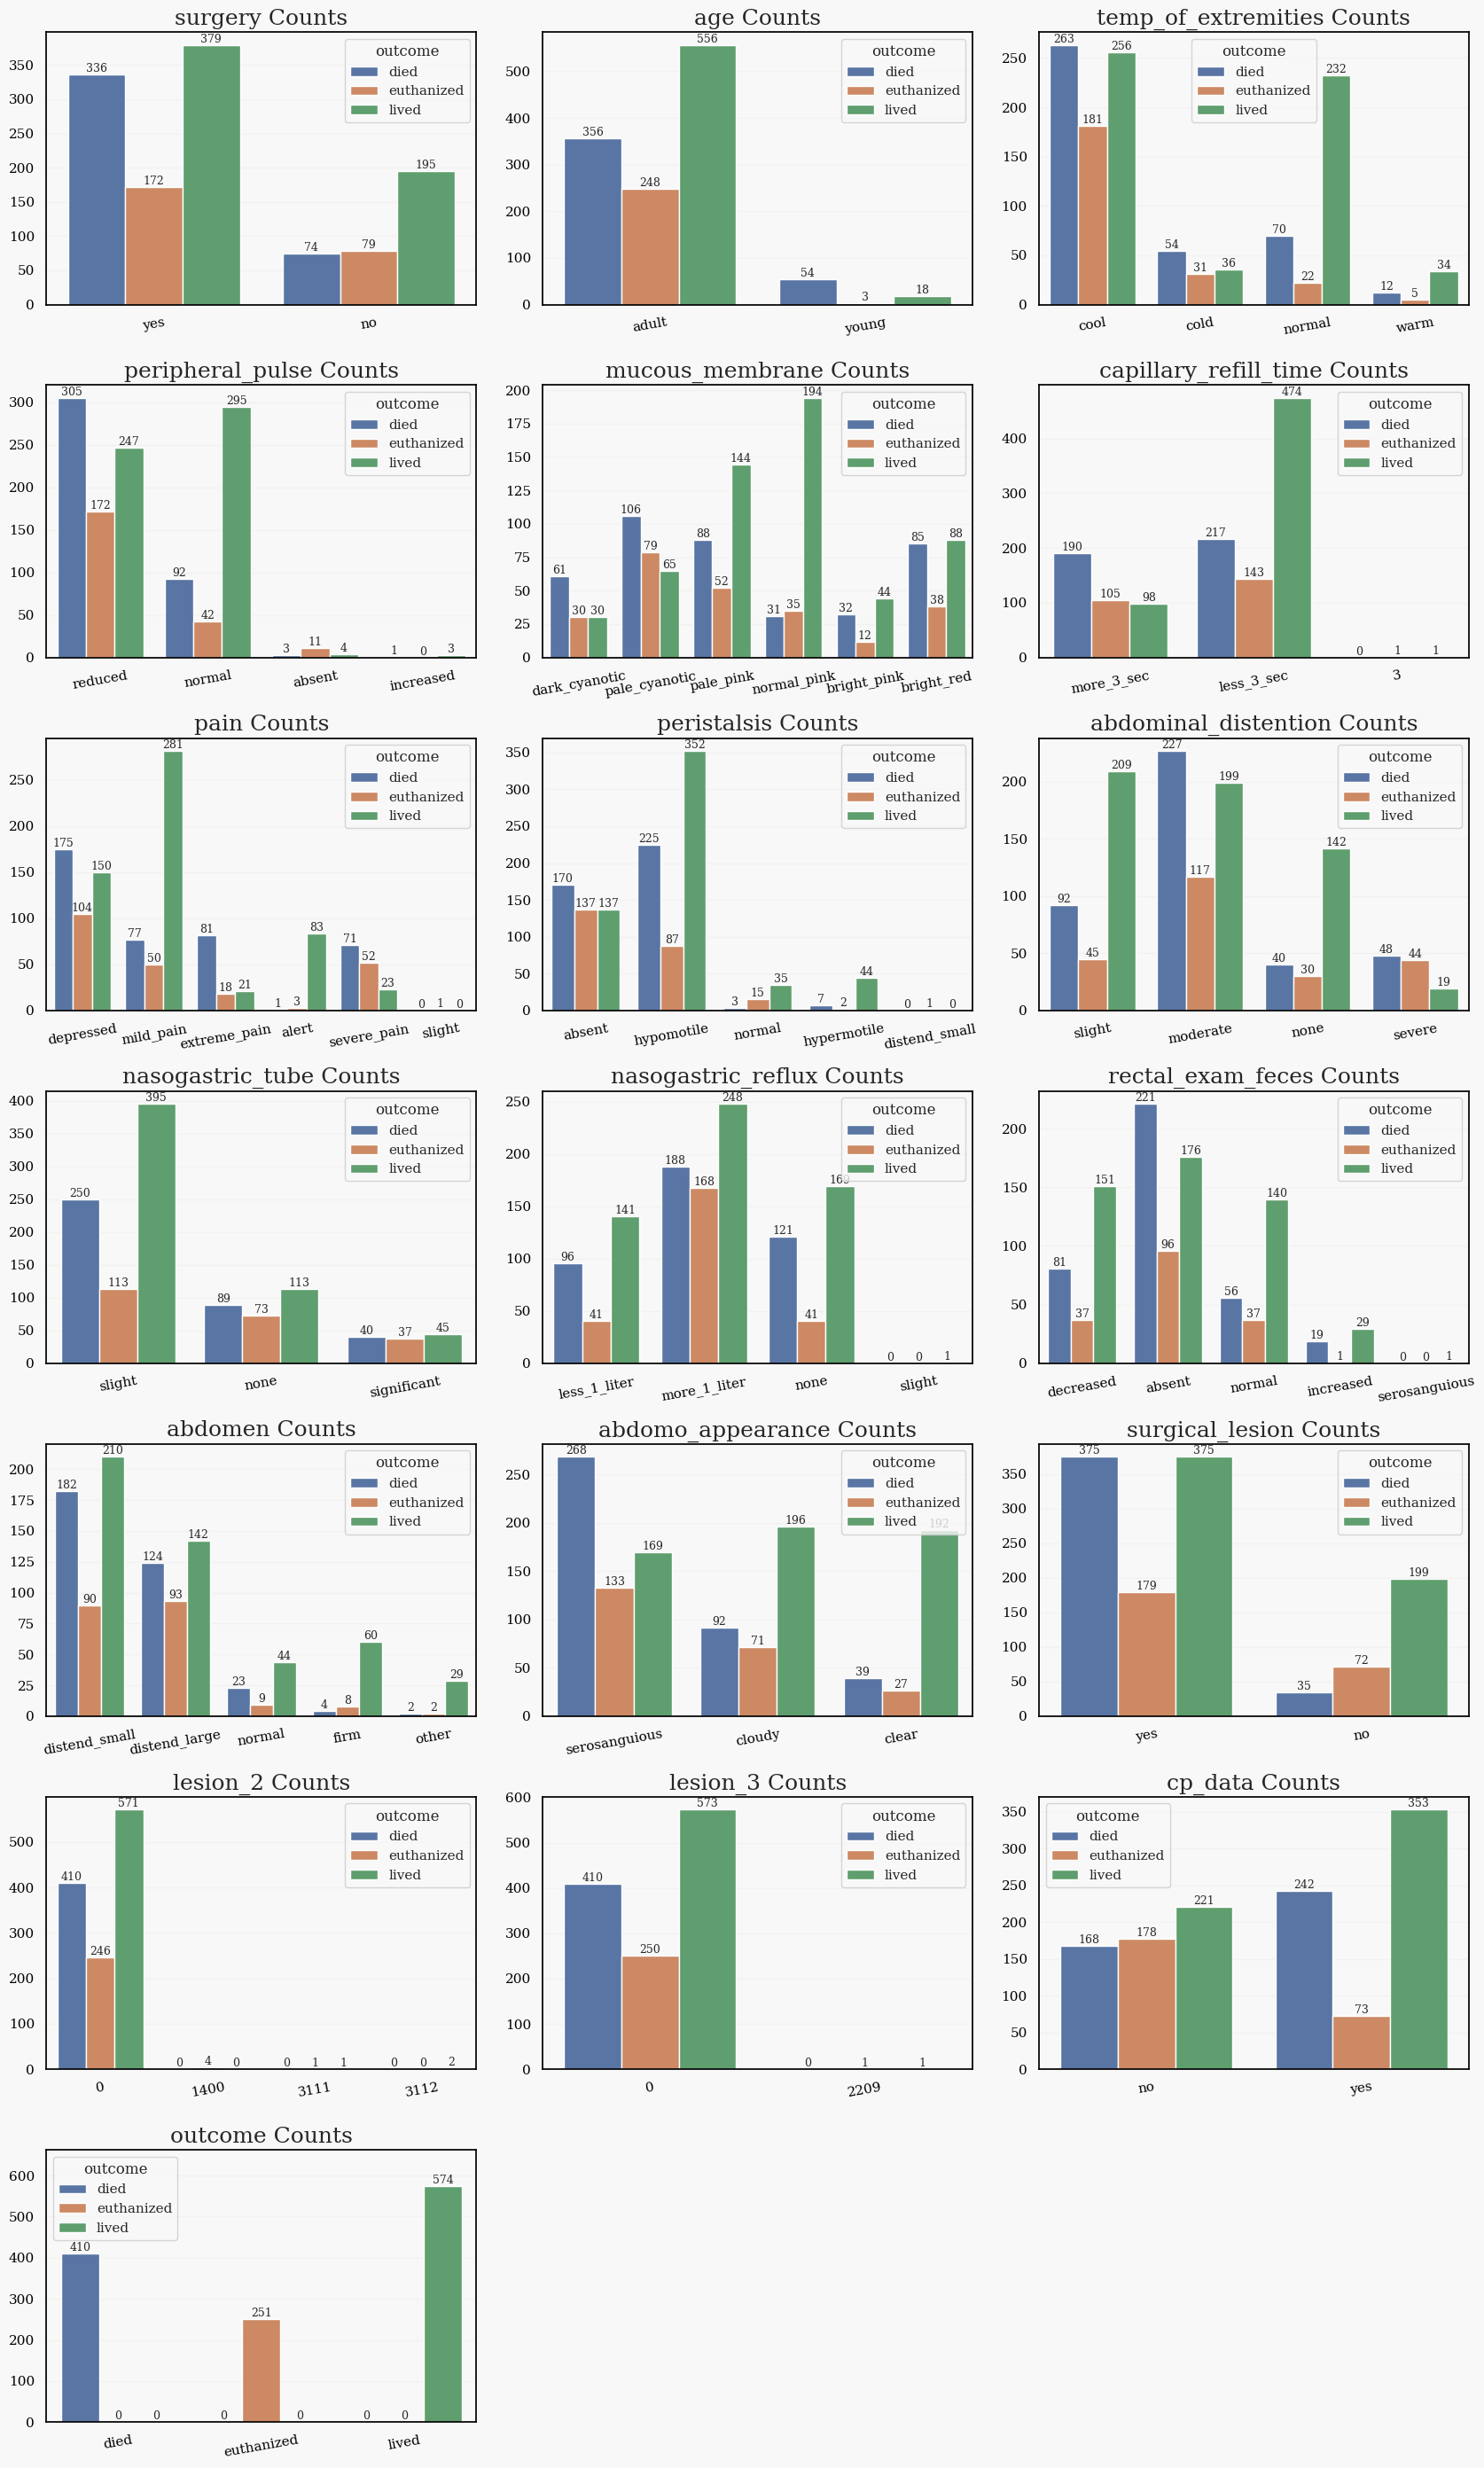

In [10]:
columns_cat = [column for column in train.columns if train[column].nunique() < 10]

def plot_count(df,columns,n_cols,hue):
    '''
    # Function to genear countplot
    df: total data
    columns: category variables
    n_cols: num of cols
    '''
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
    ax = ax.flatten()
    
    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i],hue=hue)

        # Titles
        ax[i].set_title(f'{column} Counts', fontsize=18)
        ax[i].set_xlabel(None, fontsize=16)
        ax[i].set_ylabel(None, fontsize=16)
        ax[i].tick_params(axis='x', rotation=10)

        for p in ax[i].patches:
            value = int(p.get_height())
            ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='bottom', fontsize=9)

    ylim_top = ax[i].get_ylim()[1]
    ax[i].set_ylim(top=ylim_top * 1.1)
    for i in range(len(columns), len(ax)):
        ax[i].axis('off')

    # fig.suptitle(plotname, fontsize=25, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
plot_count(train,columns_cat,3,'outcome')

**Some observations:**

1. `lesion_2 Counts` and `lesion_3 Counts` appear to have similar distributions. When they are not 0, the horse has a high probability of not dying.
2. When `cp_data_Counts` is Yes, the target variable is `euthanized` with a small probability.

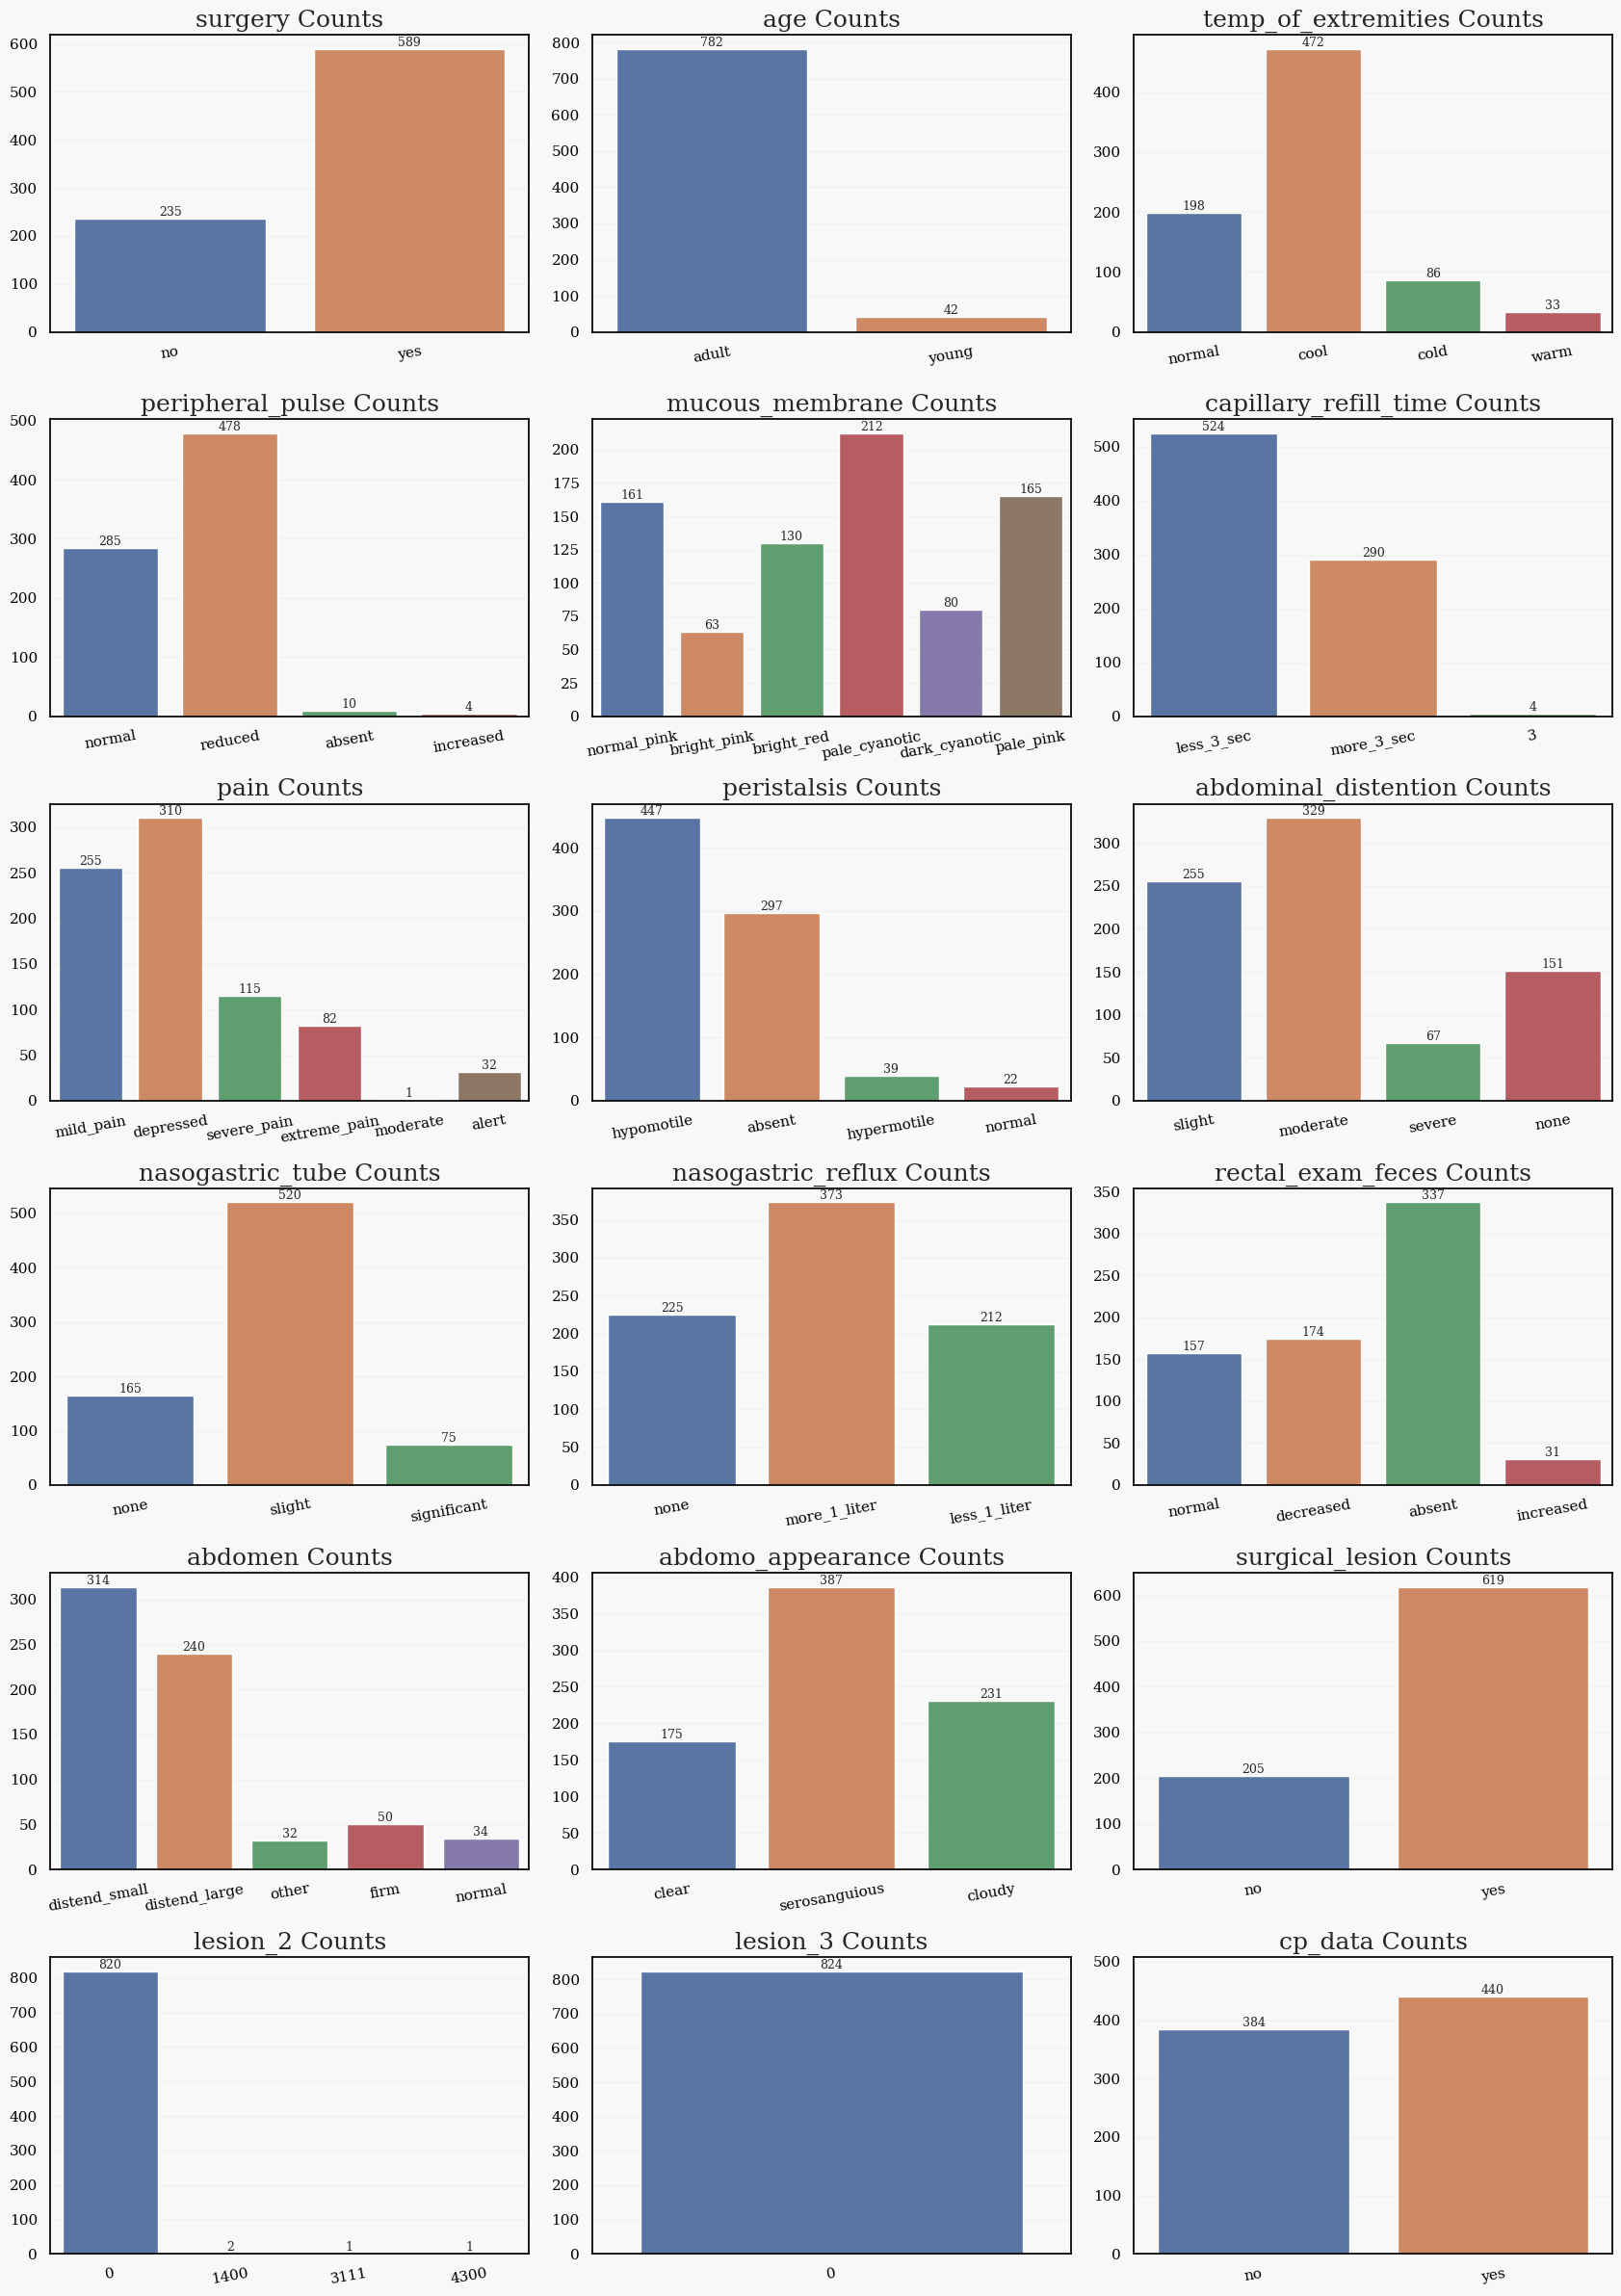

In [11]:
columns_cat = [column for column in train.columns if train[column].nunique() < 10 and column != target]
plot_count(test,columns_cat,3,None)

There are data imbalances in some features, which are manifested in:
1. The `age Counts` column contains a large number of adults.
2. The `peripheral_pulse_Counts` contains little number of `absent` and `increased`.
3. It Loos like `lesion_2` and `lesion_3` make no sense.

In addition, some feature labels that appear in the training set do not appear in the test set. To solve this problem, I will merge the two data after.

Now let me have a look at numerical features.

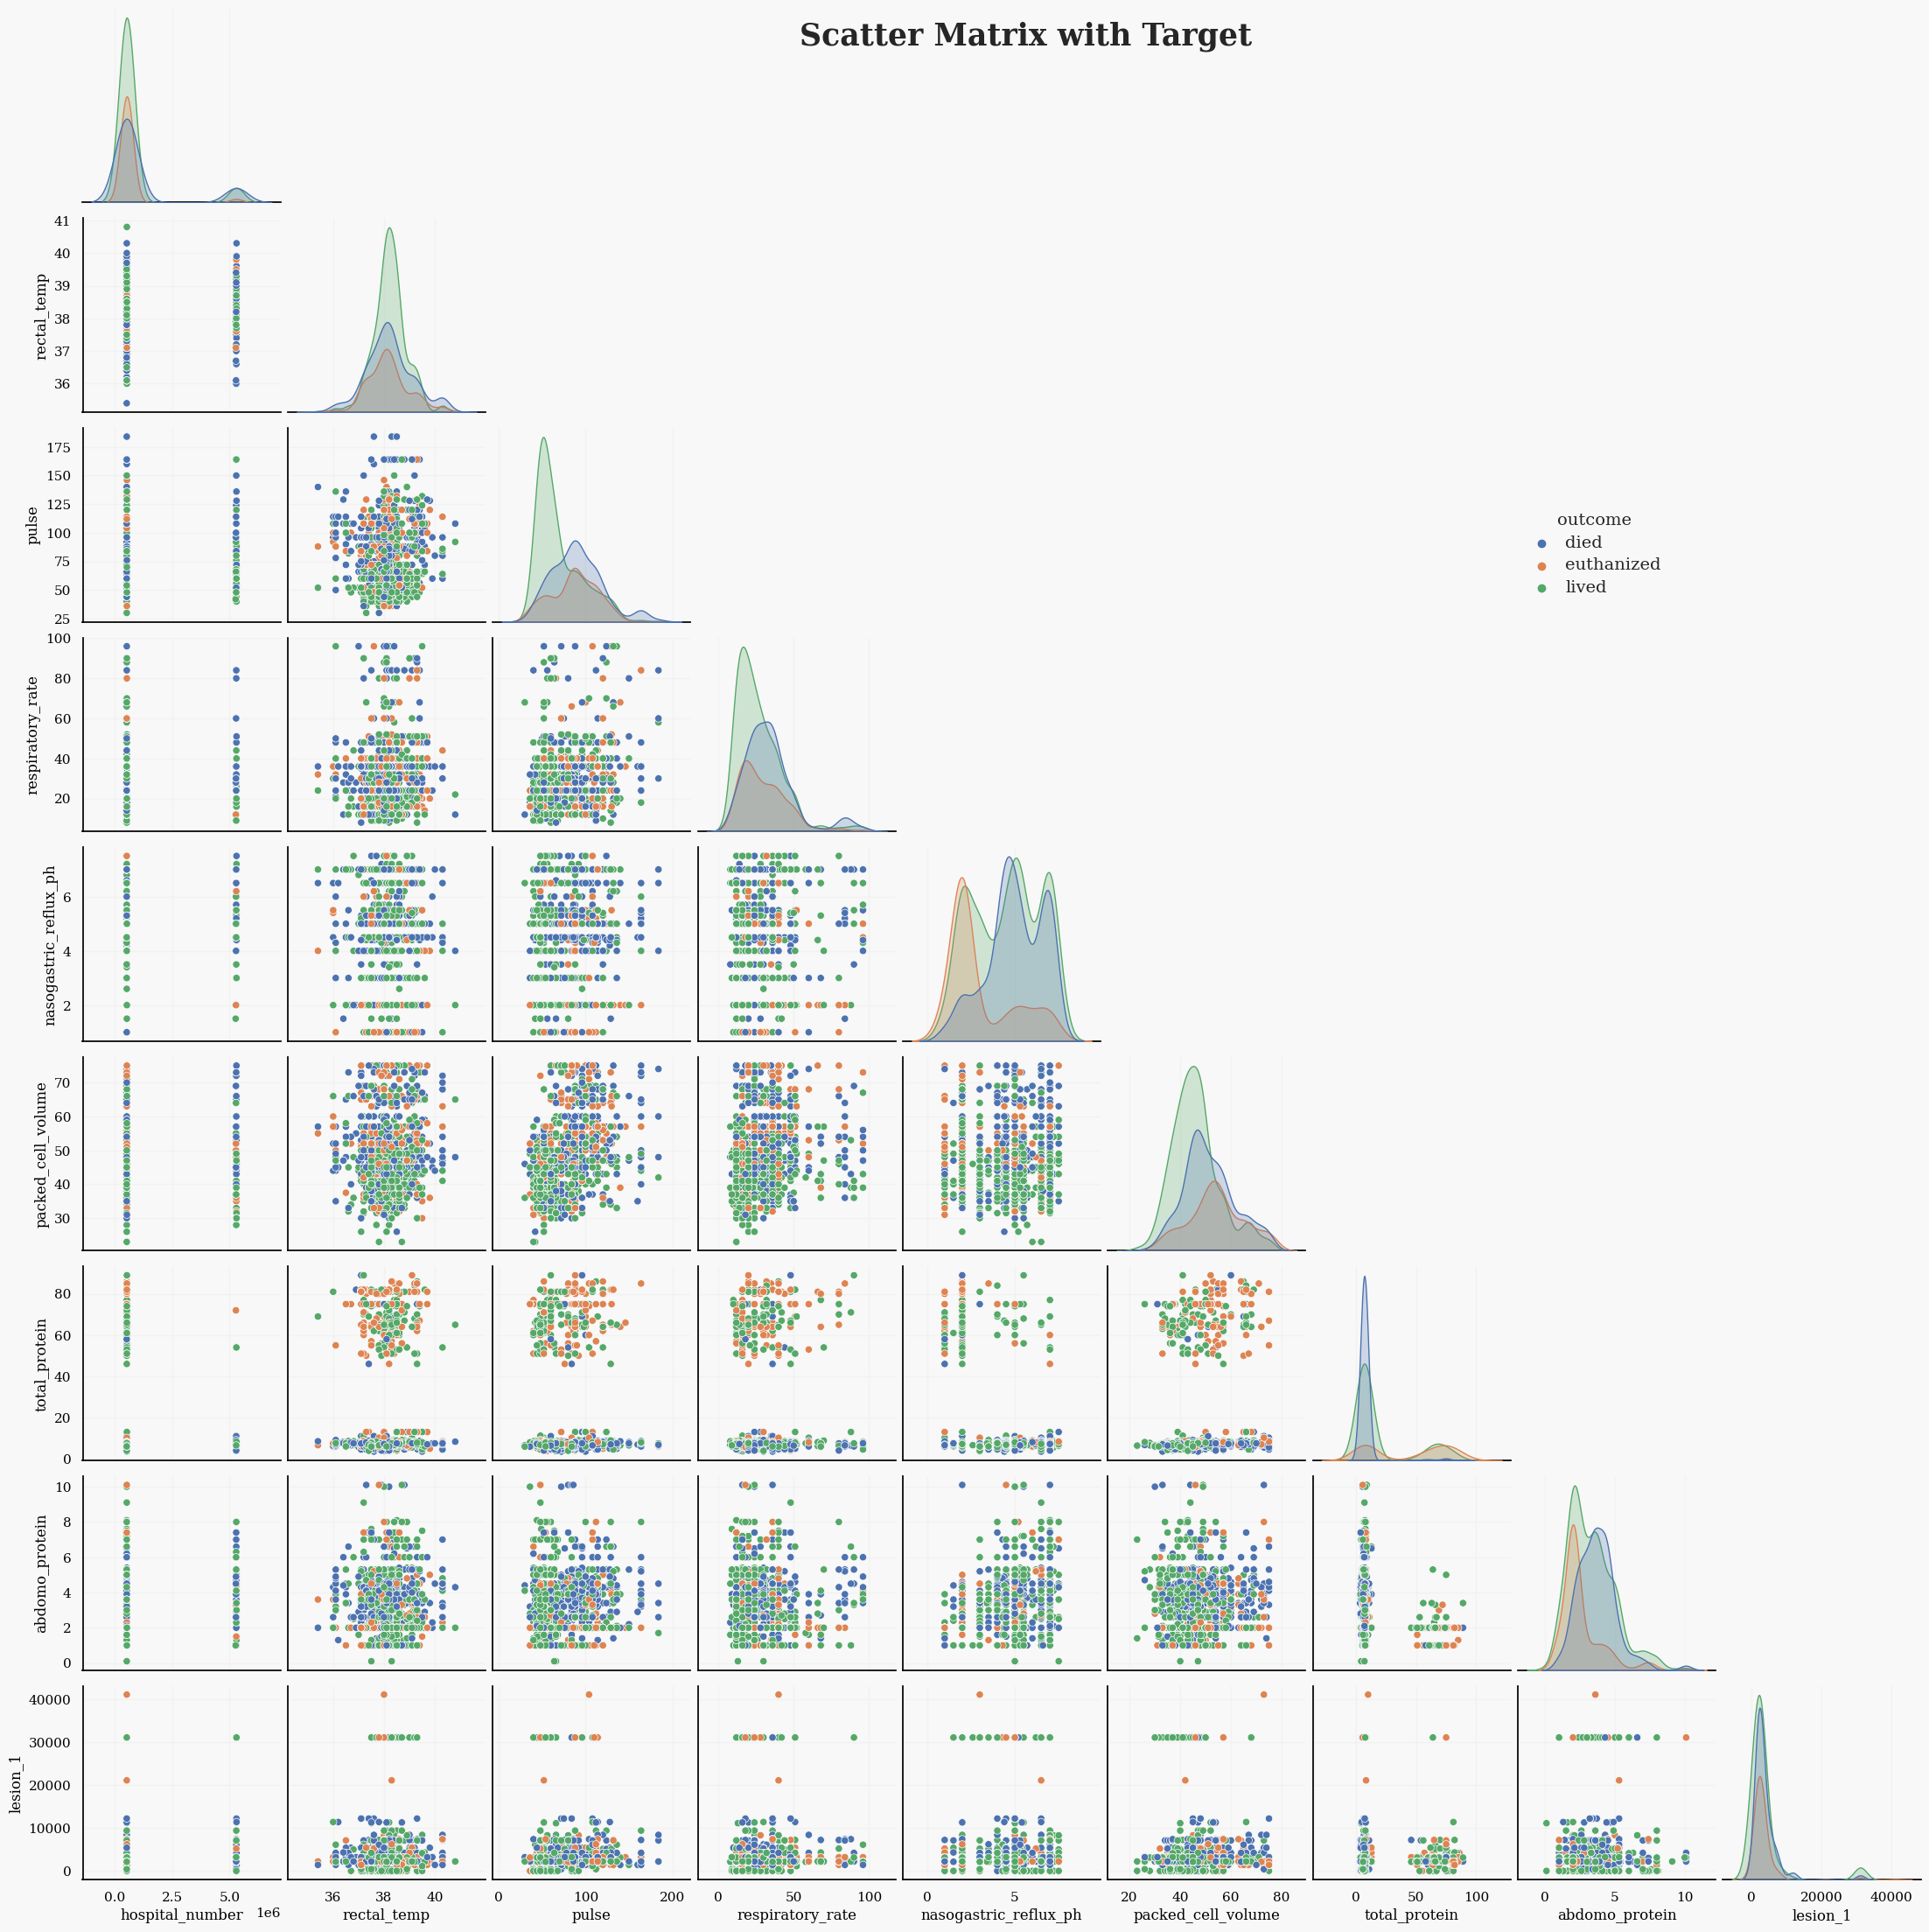

In [12]:
def plot_pair(df_train,num_var,target,plotname):
    '''
    Funtion to make a pairplot:
    df_train: total data
    num_var: a list of numeric variable
    target: target variable
    '''
    g = sns.pairplot(data=df_train, x_vars=num_var, y_vars=num_var, hue=target, corner=True)
    g._legend.set_bbox_to_anchor((0.8, 0.7))
    g._legend.set_title(target)
    g._legend.loc = 'upper center'
    g._legend.get_title().set_fontsize(14)
    for item in g._legend.get_texts():
        item.set_fontsize(14)

    plt.suptitle(plotname, ha='center', fontweight='bold', fontsize=25, y=0.98)
    plt.show()

plot_pair(train,num_var,target,plotname = 'Scatter Matrix with Target')

**Some obeservation:**

1. `Total protein` appears to related with the target.
2. There is no obvious linear relationship between numerical features.

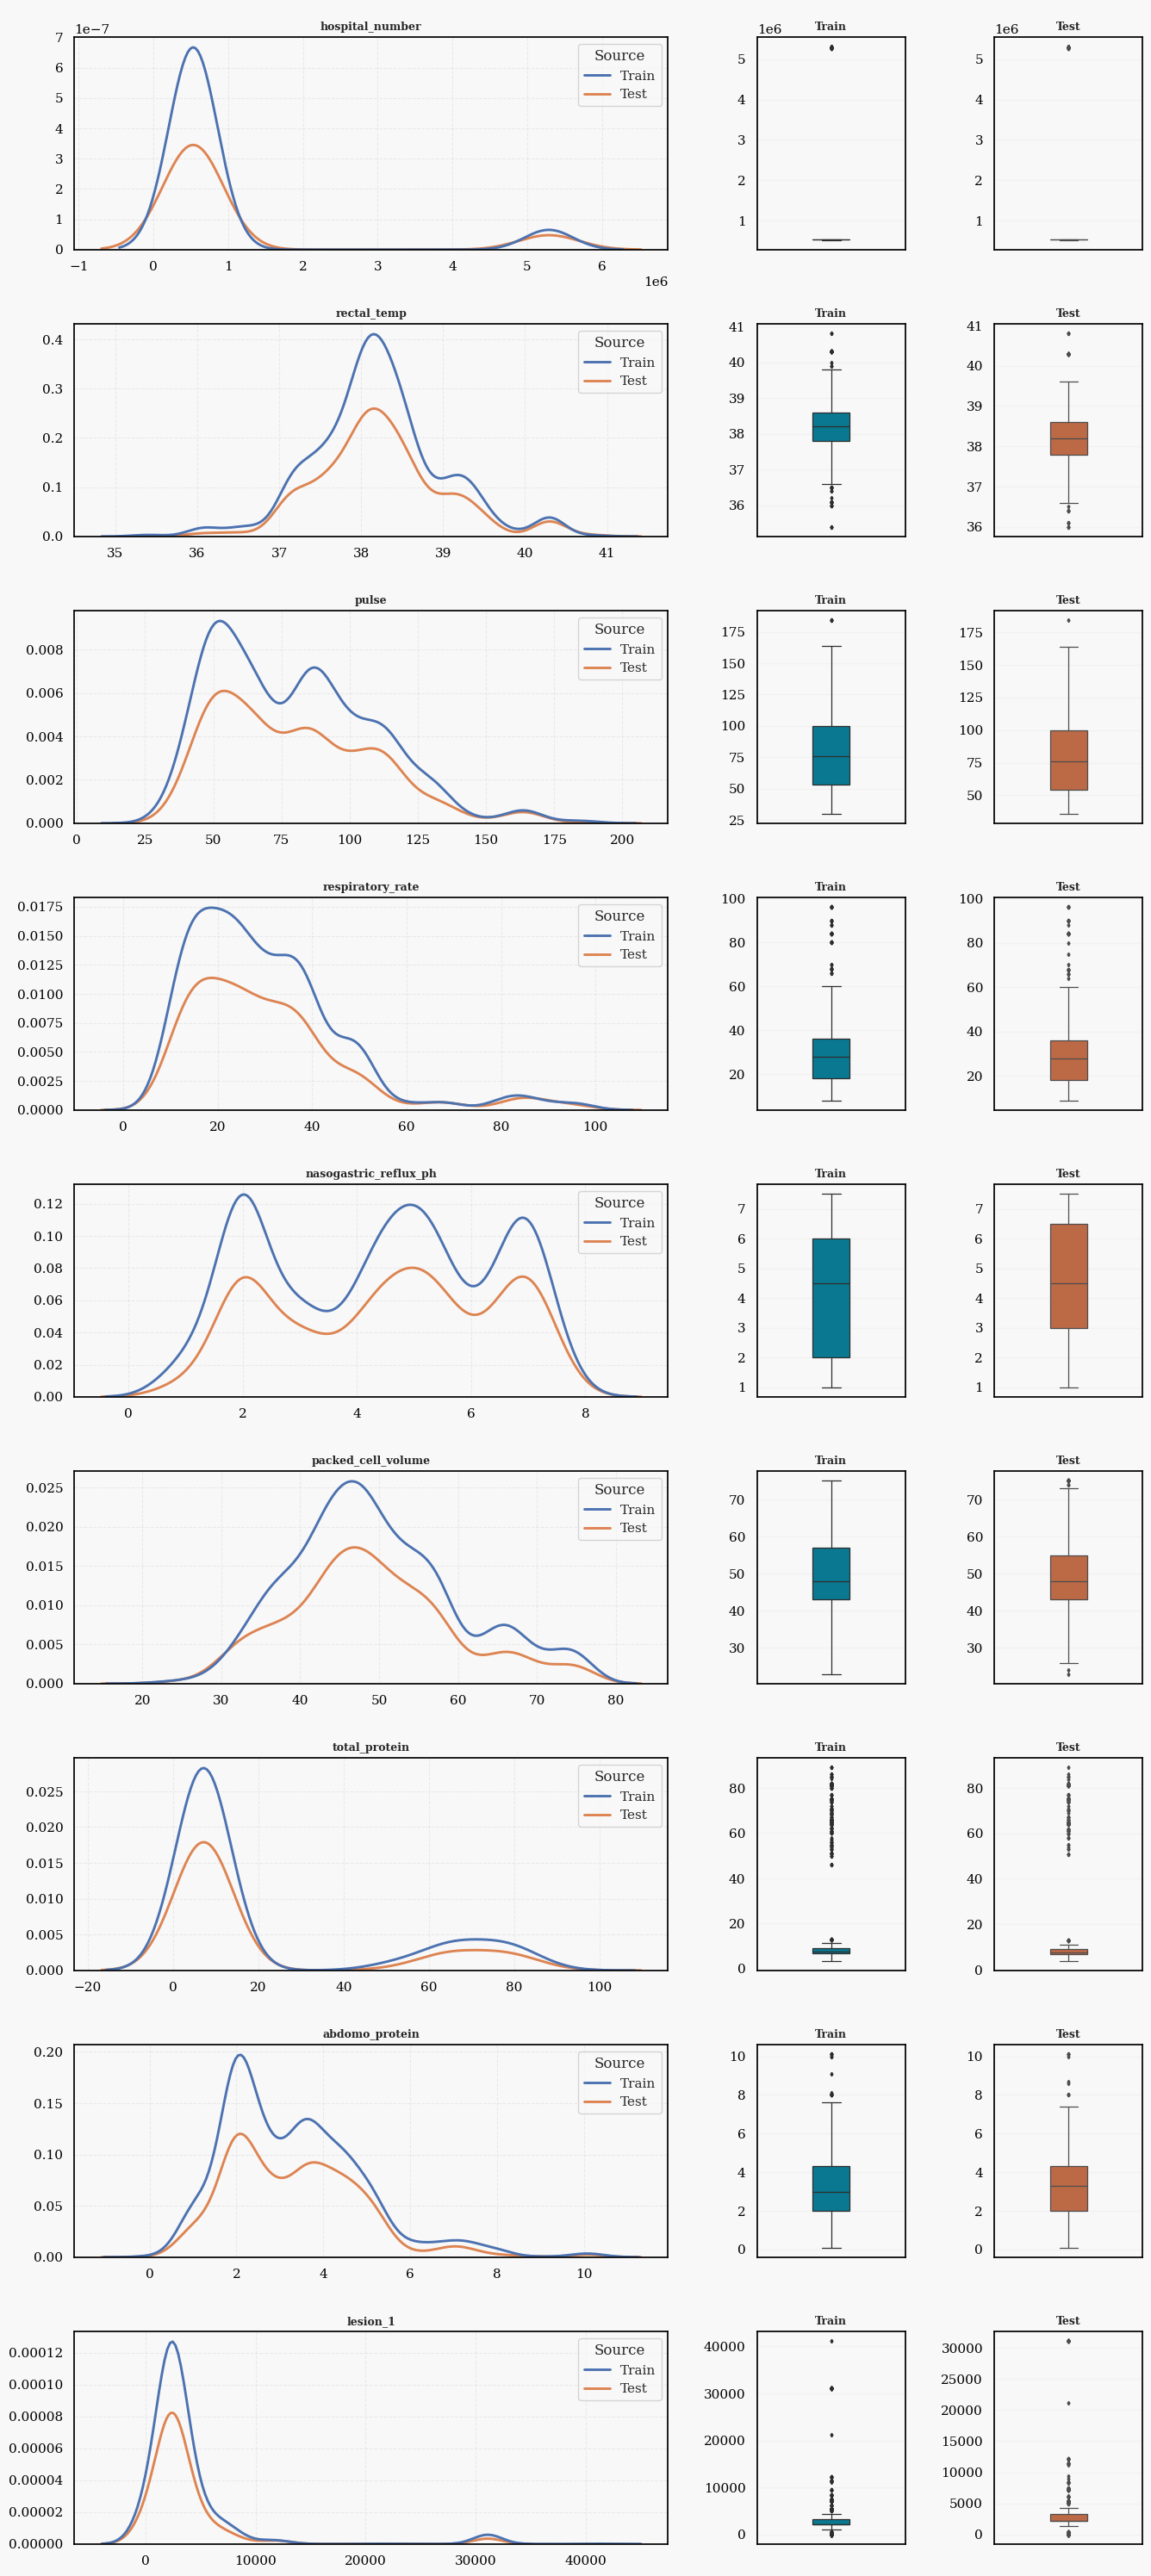

In [13]:
df = pd.concat([train[num_var].assign(Source = 'Train'), 
                test[num_var].assign(Source = 'Test')], 
               axis=0, ignore_index = True);

fig, axes = plt.subplots(len(num_var), 3 ,figsize = (16, len(num_var) * 4.2), 
                         gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]});

for i,col in enumerate(num_var):
    ax = axes[i,0];
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', ax = ax, linewidth = 2.1)
    ax.set_title(f"\n{col}",fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');
    ax = axes[i,1];
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,saturation = 0.90, linewidth = 0.90, fliersize= 2.25, color = '#037d97',
                ax = ax);
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Train",fontsize = 9, fontweight= 'bold');

    ax = axes[i,2];
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                saturation = 0.6, linewidth = 0.90, color = '#E4591E',
                ax = ax); 
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Test",fontsize = 9, fontweight= 'bold');

plt.tight_layout();
plt.show();


**Now, let's look at the distribution of numerical features in the training set.**

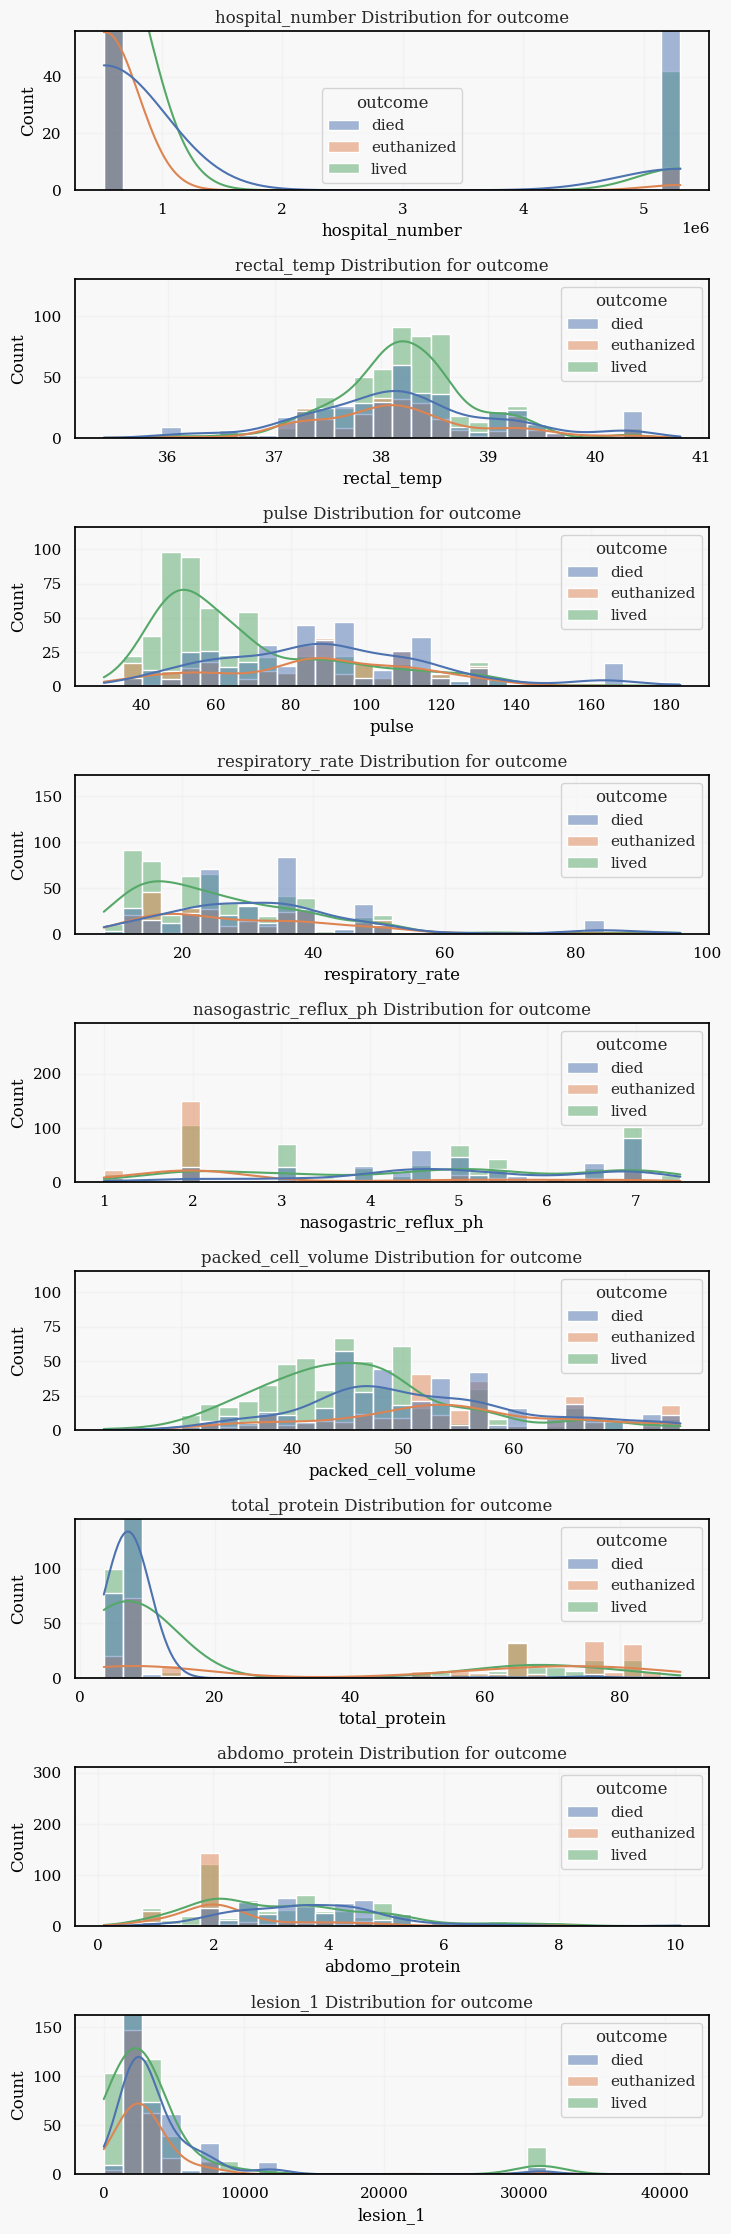

In [14]:
plt.figure(figsize=(14, len(num_var) * 2.5))

for idx, column in enumerate(num_var):
    plt.subplot(len(num_var), 2, idx*2+1)
    sns.histplot(x=column, hue="outcome", data=train, bins=30, kde=True)
    plt.title(f"{column} Distribution for outcome")
    plt.ylim(0, train[column].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

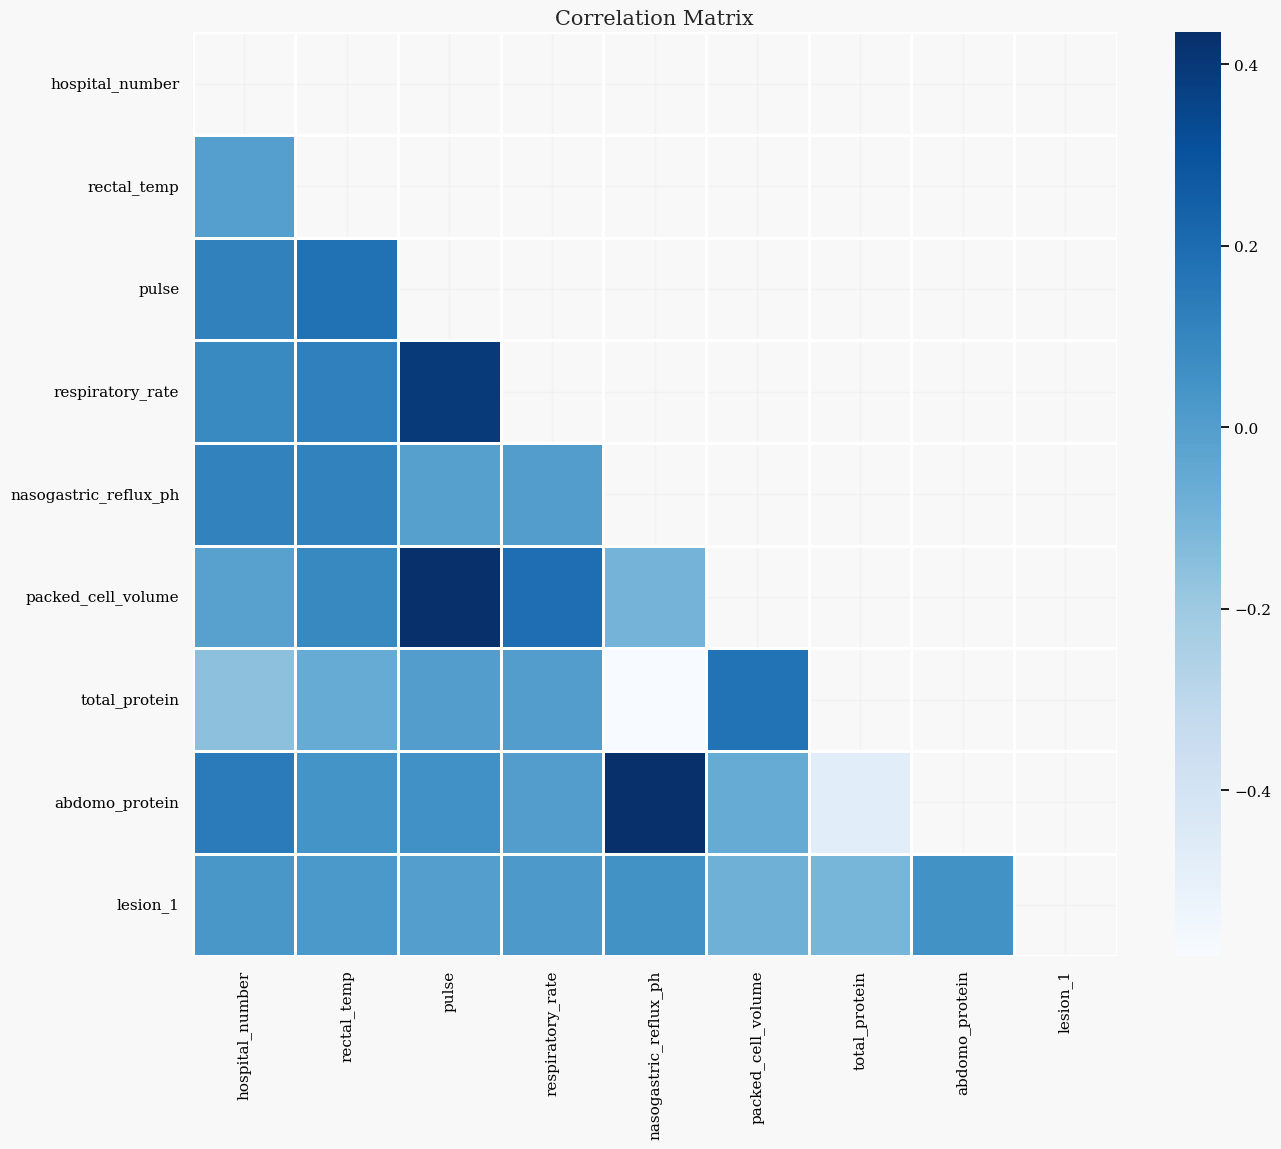

In [15]:
corr_matrix = train[num_var].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

# 3. Preprocessing and Features Selections

+ During feature selection, I can perform the following tests:
    + For categorical variables, a chi-square test will be performed to observe their relationship with the target.
    + We can also use SFS and RFECV for automatic feature selection.

You can find a complete and detailed tutorial in this [notebook](https://www.kaggle.com/code/alvinleenh/ps3e21-6-basic-feature-selection-techniques), written by [DR. ALVINLEENH](https://www.kaggle.com/alvinleenh).

## Some test

Before doing data preprocessing, I would like to perform a chi-square test.

In [16]:
def chi_squared_test(df, input_var, target_var, significance_level=0.05):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
    if p < significance_level:
        print(f'\033[32m{input_var} has a significant relationship with the target variable.\033[0m') 
    else:
        print(f'\033[31m{input_var} does not have a significant relationship with the target variable.\033[0m')  

for i in cat_var:
    chi_squared_test(train, i, target)

temp_of_extremities has a significant relationship with the target variable.
peripheral_pulse has a significant relationship with the target variable.
mucous_membrane has a significant relationship with the target variable.
capillary_refill_time has a significant relationship with the target variable.
pain has a significant relationship with the target variable.
peristalsis has a significant relationship with the target variable.
abdominal_distention has a significant relationship with the target variable.
nasogastric_tube has a significant relationship with the target variable.
nasogastric_reflux has a significant relationship with the target variable.
rectal_exam_feces has a significant relationship with the target variable.
abdomen has a significant relationship with the target variable.
abdomo_appearance has a significant relationship with the target variable.
lesion_2 has a significant relationship with the target variable.
surgery has a significant relationship with the target va

In this case,`lesion_3` will be dropped.

In [17]:
# I'm trying to keep lesion_3 in version 48, let's see if it works better.

# train.drop('lesion_3',axis=1,inplace=True)
# total.drop('lesion_3',axis=1,inplace=True)
# cat_var.remove('lesion_3')

## Preprocessing

In [18]:
# Mapping target to numbers

total[target] = total[target].map({'died':0,'euthanized':1,'lived':2})

I adopted [@MATT OP](https://www.kaggle.com/code/mattop/ps-s3-e22-xgboost-preprocessing)'s preprocessing function and added new features based on it. Let's see how it works.

Unlike me doing one-hot encoding of all categorical variables, he did Ordinal encoding based on the meaning of the features.

Another benefit of this approach is that the number of features is greatly reduced.

In [19]:
# Data preprocessing, code sourse: https://www.kaggle.com/code/mattop/ps-s3-e22-xgboost-preprocessing
def preprocessing(df, le_cols, ohe_cols):
    
    # Label Encoding for binary cols
    le = LabelEncoder()    
    for col in le_cols:
        df[col] = le.fit_transform(df[col])
    
    # OneHot Encoding for category cols
    df = pd.get_dummies(df, columns = ohe_cols)
    
    df["pain"] = df["pain"].replace('slight', 'moderate')
    df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
    df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
    df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')
        
    df["temp_of_extremities"] = df["temp_of_extremities"].fillna("normal").map({'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3})
    df["peripheral_pulse"] = df["peripheral_pulse"].fillna("normal").map({'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3})
    df["capillary_refill_time"] = df["capillary_refill_time"].fillna("3").map({'less_3_sec': 0, '3': 1, 'more_3_sec': 2})
    df["pain"] = df["pain"].fillna("depressed").map({'alert': 0, 'depressed': 1, 'moderate': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5})
    df["peristalsis"] = df["peristalsis"].fillna("hypomotile").map({'hypermotile': 0, 'normal': 1, 'hypomotile': 2, 'absent': 3})
    df["abdominal_distention"] = df["abdominal_distention"].fillna("none").map({'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3})
    df["nasogastric_tube"] = df["nasogastric_tube"].fillna("none").map({'none': 0, 'slight': 1, 'significant': 2})
    df["nasogastric_reflux"] = df["nasogastric_reflux"].fillna("none").map({'less_1_liter': 0, 'none': 1, 'more_1_liter': 2})
    df["rectal_exam_feces"] = df["rectal_exam_feces"].fillna("absent").map({'absent': 0, 'decreased': 1, 'normal': 2, 'increased': 3})
    df["abdomen"] = df["abdomen"].fillna("distend_small").map({'normal': 0, 'other': 1, 'firm': 2,'distend_small': 3, 'distend_large': 4})
    df["abdomo_appearance"] = df["abdomo_appearance"].fillna("serosanguious").map({'clear': 0, 'cloudy': 1, 'serosanguious': 2})
    
    # Imputer 
    cols_with_nan = df.drop(target,axis=1).columns[df.drop(target,axis=1).isna().any()].tolist()
    for feature in cols_with_nan:
        df[feature].fillna(df[feature].mode()[0], inplace=True)
     
    return df  

In [20]:
total = preprocessing(total, le_cols = ["surgery", "age", "surgical_lesion", "cp_data"], ohe_cols = ["mucous_membrane"])

I stopped using the feature engineering function after version 50 because in my tests it caused a 0.1 drop in public scores.

In [21]:
df_train = total[total[target].notna()]
df_test = total[total[target].isna()]
df_test.drop(target,axis=1,inplace=True)

In [22]:
full_features = df_test.columns.tolist()
bin_features = df_test.select_dtypes('bool').columns

df_train[bin_features] = df_train[bin_features].astype('int64')
df_test[bin_features] = df_test[bin_features].astype('int64')

In [23]:
df_train.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink
0,1,0,530001,38.1,132.0,24.0,1,1,2,1,3,1,1,0,6.5,1,3,57.0,8.5,2,3.4,1,2209,0,0,0,0.0,0,0,1,0,0,0
1,1,0,533836,37.5,88.0,12.0,1,2,2,3,3,2,0,2,2.0,0,3,33.0,64.0,2,2.0,1,2208,0,0,0,1.0,0,0,0,0,1,0
2,1,0,529812,38.3,120.0,28.0,1,1,0,5,2,2,1,1,3.5,0,4,37.0,6.4,2,3.4,1,5124,0,0,0,2.0,0,0,0,0,0,1
3,1,0,5262541,37.1,72.0,30.0,0,1,2,3,2,2,1,2,2.0,1,3,53.0,7.0,1,3.9,1,2208,0,0,1,2.0,0,0,0,0,0,1
4,0,0,5299629,38.0,52.0,48.0,2,2,0,0,2,0,1,0,7.0,2,0,47.0,7.3,1,2.6,0,0,0,0,1,2.0,0,0,0,1,0,0


## Metrics

In [24]:
# Metrics
def caculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average = 'micro')

## Baseline Model

I will build a baseline model to evaluate the results of feature selection.

In [25]:
lgbm_baseline = LGBMClassifier(n_estimators=1000,
                     max_depth=10,
                     random_state=42)

f1_results = pd.DataFrame(columns=['Selected_Features', 'F1'])

def evaluation(df, select_features, note):
    global f1_results
    
    X = df[select_features]
    Y = df[target]
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]
        
        lgbm_baseline.fit(X_train, y_train)
        y_hat = lgbm_baseline.predict(X_test) 
        f1 = caculate_f1(y_test, y_hat)
        f1_scores.append(f1)
    
    average_f1 = np.mean(f1_scores)
    new_row = {'Selected_Features': note, 'F1': average_f1}
    f1_results = pd.concat([f1_results, pd.DataFrame([new_row])], ignore_index=True)

    # f1_results = f1_results.append({'Selected_Features': note, 'F1': average_f1}, ignore_index=True)
    print('====================================')
    print(note)
    print("Average F1:", average_f1)
    print('====================================')
    return average_f1

In [26]:
evaluation(df=df_train,select_features=full_features,note='Baseline')

Baseline
Average F1: 0.7250131102669378


0.7250131102669378

## Feature Selection

There are many ways to perform feature selection.

### Correlation

This function is designed to remove multicollinearity.

In [27]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold: 
                colname = corr_matrix.columns[i]                  
                col_corr.add(colname)
    return col_corr      

corr_features = correlation(df_train, 0.35)
corr_features

{'abdominal_distention',
 'abdomo_protein',
 'capillary_refill_time',
 'cp_data',
 'lesion_3',
 'mucous_membrane_dark_cyanotic',
 'mucous_membrane_normal_pink',
 'packed_cell_volume',
 'peripheral_pulse',
 'peristalsis',
 'rectal_exam_feces',
 'respiratory_rate',
 'surgical_lesion',
 'temp_of_extremities',
 'total_protein'}

In [28]:
corr_features = df_test.drop(['abdominal_distention',
 'abdomo_protein',
 'capillary_refill_time',
 'cp_data',
 'lesion_3',
 'mucous_membrane_dark_cyanotic',
 'mucous_membrane_normal_pink',
 'packed_cell_volume',
 'peripheral_pulse',
 'peristalsis',
 'rectal_exam_feces',
 'respiratory_rate',
 'surgical_lesion',
 'temp_of_extremities',
 'total_protein'],axis=1).columns.tolist()

In [29]:
evaluation(df=df_train,select_features=corr_features,note='Corr Features')

Corr Features
Average F1: 0.7139109525088574


0.7139109525088574

### Features Importance

In [30]:
def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title(f'Feature importances', size=16, y=1.05, 
              fontweight='bold')
    a = sns.barplot(data=f_imp, x='imp', y='feature', linestyle="-", 
                    linewidth=0.5, edgecolor="black",palette='GnBu')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11)
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()

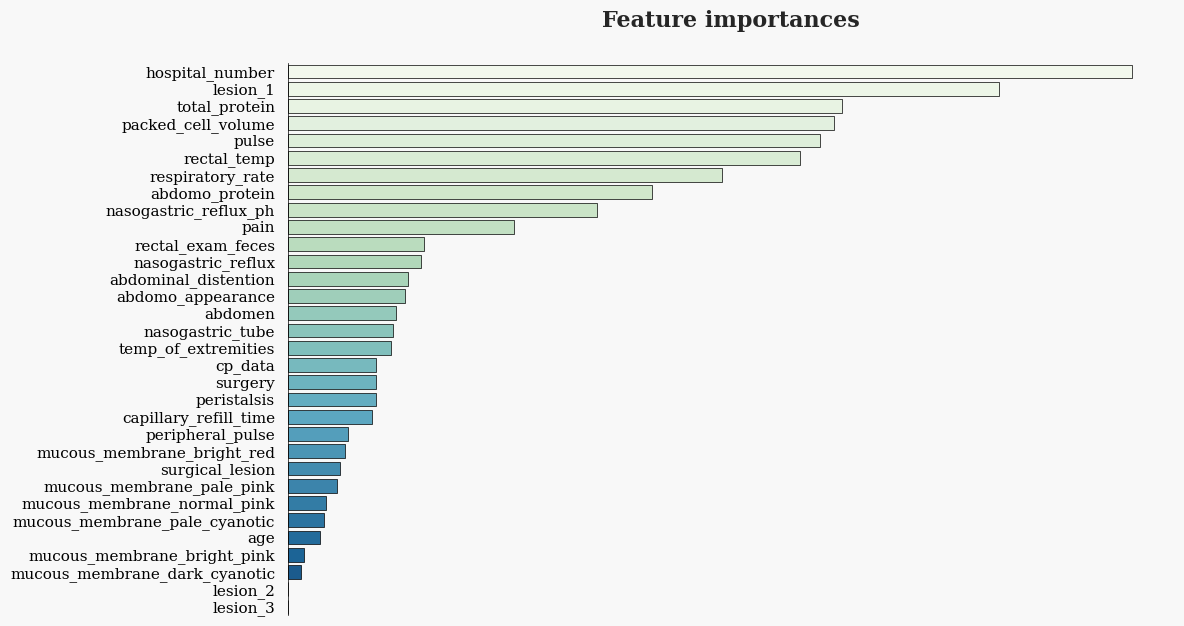

In [31]:
clf = LGBMClassifier(n_estimators=1000,
                     max_depth=10,
                     random_state=42)
clf.fit(df_train.drop(target,axis=1), df_train[target])

f_imp_df = pd.DataFrame({'feature': df_train.drop(target,axis=1).columns, 'imp': clf.feature_importances_})
f_imp_df.sort_values(by='imp',ascending=False,inplace=True)
f_importance_plot(f_imp_df)

In [32]:
# %%time
# Cost time: 13min30s
# best_score = 0
# best_feature_num = 0
# for i in range(1,f_imp_df.shape[0]):
#     feature = f_imp_df.head(i).feature.to_list()
#     # print(f'Trying top {i} features...')
#     score = evaluation(df=df_train,select_features=feature,note=f'Top {i} Features')
#     if score > best_score:
#         best_score = score
#         best_feature_num = i

In [33]:
best_feature_num = 30
best_score = 0.7392406127690802
print(f'Best feature number is Top {best_feature_num}, Best score is {best_score}')

Best feature number is Top 30, Best score is 0.7392406127690802


From this result, it appears that the top 30 features perform best in cross-validation.

In [34]:
best_features = f_imp_df.head(best_feature_num).feature.to_list()

# 4. Modeling

In version 54, I removed the use of mode imputing, because the public scores after filling were not as high as the scores that retained the missing values. Therefore, I only kept the tree model that allowed for missing values.

In [35]:
xgb_cv_scores, xgb_preds = list(), list()
lgbm_cv_scores, lgbm_preds = list(), list()
cat_cv_scores, cat_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()


sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)

X = df_train[best_features]
Y = df_train[target]

df_pred = df_test[best_features]

for i, (train_ix, test_ix) in enumerate(sk.split(X,Y)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ## XGBClassifer
    xgb_md = XGBClassifier(n_estimators=1000, 
                           max_depth=3, 
                           early_stopping_rounds=50,
                           learning_rate=0.55,
                           min_child_weight=2,
                           colsample_bytree=0.9,
                           objective='multi:softmax',
                           eval_metric='merror',
                           random_state=1).fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=10000)
    xgb_pred = xgb_md.predict(X_test)   
    xgb_f1 = caculate_f1(Y_test, xgb_pred)  
    print('Fold', i+1, '==> XGBoost oof F1 score is ==>', xgb_f1)
    xgb_cv_scores.append(xgb_f1)
    
    ## Pred
    xgb_pred_test = xgb_md.predict_proba(df_pred)
    xgb_preds.append(xgb_pred_test)
    
    ## LightGBM
    lgbm_md = LGBMClassifier(n_estimators=100, random_state=42).fit(X_train, Y_train)
    lgbm_pred = lgbm_md.predict(X_test)   
    lgbm_f1 = caculate_f1(Y_test, lgbm_pred)  
    print('Fold', i+1, '==> LightGBM oof F1 score is ==>', lgbm_f1)
    lgbm_cv_scores.append(lgbm_f1)
    
    ## Pred
    lgbm_pred_test = lgbm_md.predict_proba(df_pred)
    lgbm_preds.append(lgbm_pred_test)
    
    
    ## CatBoost
    cat_md = CatBoostClassifier(loss_function = 'MultiClass',
                                iterations = 500,
                                learning_rate = 0.01,
                                depth = 7,
                                random_strength = 0.5,
                                bagging_temperature = 0.7,
                                border_count = 30,
                                l2_leaf_reg = 5,
                                verbose = False, 
                                task_type = 'CPU').fit(X_train, Y_train)
    cat_pred = cat_md.predict(X_test)   
    cat_f1 = caculate_f1(Y_test, cat_pred)  
    print('Fold', i+1, '==> CatBoost oof F1 score is ==>', cat_f1)
    cat_cv_scores.append(cat_f1)
    
    ## Pred
    cat_pred_test = cat_md.predict_proba(df_pred)
    cat_preds.append(cat_pred_test)
    
    ## HistGradientBoosting
    hist_md = HistGradientBoostingClassifier(
                            max_depth=4,          
                            max_iter=80,         
                            learning_rate=0.1,     
                            random_state=42,   
                            scoring='f1_micro',          
                            max_leaf_nodes = 21,
                            l2_regularization = 0.1).fit(X_train, Y_train)
    hist_pred = hist_md.predict(X_test)   
    hist_f1 = caculate_f1(Y_test, hist_pred)  
    print('Fold', i+1, '==> Hist Gradient Boosting oof F1 score is ==>', hist_f1)
    hist_cv_scores.append(hist_f1)
    
    ## Pred
    hist_pred_test = hist_md.predict_proba(df_pred)
    hist_preds.append(hist_pred_test)    
    
    

print('---------------------------------------------------------------')
print('Average Accuracy of XGBoost model is:', np.mean(xgb_cv_scores))
print('Average Accuracy of LGBM model is:', np.mean(lgbm_cv_scores))
print('Average Accuracy of Catboost model is:', np.mean(cat_cv_scores))
print('Average Accuracy of Hist Gradient Boosting model is:', np.mean(hist_cv_scores))

---------------------------------------------------------------
[0]	validation_0-merror:0.32899
[60]	validation_0-merror:0.30945
Fold 1 ==> XGBoost oof F1 score is ==> 0.7068403908794788
Fold 1 ==> LightGBM oof F1 score is ==> 0.729641693811075
Fold 1 ==> CatBoost oof F1 score is ==> 0.6807817589576547
Fold 1 ==> Hist Gradient Boosting oof F1 score is ==> 0.7328990228013029
---------------------------------------------------------------
[0]	validation_0-merror:0.33660
[77]	validation_0-merror:0.30065
Fold 2 ==> XGBoost oof F1 score is ==> 0.7254901960784313
Fold 2 ==> LightGBM oof F1 score is ==> 0.6895424836601307
Fold 2 ==> CatBoost oof F1 score is ==> 0.7026143790849673
Fold 2 ==> Hist Gradient Boosting oof F1 score is ==> 0.6764705882352942
---------------------------------------------------------------
[0]	validation_0-merror:0.28105
[131]	validation_0-merror:0.24837
Fold 3 ==> XGBoost oof F1 score is ==> 0.7581699346405228
Fold 3 ==> LightGBM oof F1 score is ==> 0.722222222222222

In [36]:
def get_submission(prob_list,model_name):
    '''
    This function will obtain the probability of each prediction result of the model and generate the final prediction.
    '''
    average_probabilities = np.mean(prob_list, axis=0)
    final_predictions = []
    for proba in average_probabilities:
        predicted_label = np.argmax(proba)
        final_predictions.append(predicted_label)        
        
    submission = pd.DataFrame({'id': sample_submission['id'], 'outcome': final_predictions})
    submission['outcome'] = submission['outcome'].map({0:'died',1:'euthanized',2:'lived'})
    submission.to_csv(f'{model_name}_submission.csv',index=False)
    print(f'Result:{model_name}_submission is saved!')

    return submission

In [37]:
sub_lgbm = get_submission(lgbm_preds,'lgbm')
sub_xgb = get_submission(xgb_preds,'xgb')
sub_cat = get_submission(cat_preds,'catboost')
sub_hist = get_submission(hist_preds,'histgradientboost')

Result:lgbm_submission is saved!
Result:xgb_submission is saved!
Result:catboost_submission is saved!
Result:histgradientboost_submission is saved!


We can take a look at the F1 result to find which model is better.

In [38]:
f1_results.sort_values('F1',ascending=False)

,Selected_Features,F1
0,Baseline,0.725013
1,Corr Features,0.713911


# 5. Final Prediction

In [39]:
# Get final prediction
preds = [sub_lgbm,sub_xgb,sub_cat,sub_hist]
merged_df = pd.concat(preds)
final_predictions = merged_df.groupby('id')['outcome'].apply(lambda x: x.mode().iloc[0]).reset_index()
final_predictions.to_csv('final_preds.csv',index=False)

# 6. Hyperparameter optimization of individual models

In this part, I will try to find the best hyperparameters for each base model.

## Optuna

In [40]:
# def objective(trial, data=X, target=Y):
#     x_train, x_val, y_train, y_val = train_test_split(data, target, test_size=0.18,random_state=3317)
    
#     param = {
#     'eval_metric': ['merror', 'mlogloss'], 
#     'n_estimators': 1000,
#     'objective':'multi:softmax',
#     'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#     'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
#     'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
#     'gamma': trial.suggest_int('gamma', 1, 20),
#     'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#     'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#     'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#     'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 1.0, 0.05),
#     'learning_rate': trial.suggest_categorical('learning_rate', [0.002, 0.004, 0.006,0.008,0.01,0.014,0.017,0.02]),
#     'max_depth': trial.suggest_int('max_depth',10,60 ),
#     'max_leaves' : trial.suggest_int('max_leaves', 1, 1000)
#     #'min_child_samples': trial.suggest_int('min_child_samples', 1, 300)
 
# }

#     model = XGBClassifier(tree_method='gpu_hist', 
#                              gpu_id=0, 
#                              predictor="gpu_predictor",**param)  
    
#     model.fit(x_train,y_train,eval_set=[(x_val, y_val)],verbose=0)   
#     preds = model.predict(x_val)   
#     score = accuracy_score(y_val, preds)
    
#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=1000)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

# LGBM

In [41]:
params_lgb = {
    'objective': 'multiclass', 
    'num_class': 3,
    'boosting_type' : 'gbdt',
    'num_leaves': 24,
    'max_depth': 10,
    'n_estimators': 450,
    'learning_rate': 0.08,
    'random_state': 42,
    'verbose': -1,
    'subsample':0.8,
    'colsample_bytree':0.65,
    'reg_alpha':0.0001,
    'reg_lambda':3.5,
    }

In [42]:
# select_features = ['surgery', 'hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'temp_of_extremities', 'mucous_membrane', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein', 'abdomo_appearance', 'abdomo_protein', 'lesion_1', 'cp_data']
X_opt = df_train[best_features]
Y_opt = df_train[target]
df_pred = df_test[best_features]

In [43]:
lgb_opt = LGBMClassifier(**params_lgb).fit(X_opt,Y_opt)
lgb_preds = lgb_opt.predict(df_pred)

lgb_opt_submission = pd.DataFrame({'id': sample_submission['id'], 'outcome': lgb_preds})
lgb_opt_submission['outcome'] = lgb_opt_submission['outcome'].map({0:'died',1:'euthanized',2:'lived'})
lgb_opt_submission.to_csv('lgb_opt_submission.csv',index=False)

## XGBoost

In [44]:
params_xgb = {'min_child_weight': 5,
 'reg_alpha': 0.014425096788083052,
 'reg_lambda': 0.012345176750382126,
 'gamma': 1,
 'colsample_bytree': 0.5,
 'colsample_bynode': 0.7,
 'colsample_bylevel': 0.7,
 'subsample': 0.95,
 'learning_rate': 0.017,
 'max_depth': 15,
 'max_leaves': 366}

In [45]:
xgb_opt = XGBClassifier(**params_xgb).fit(X_opt,Y_opt)
xgb_preds = xgb_opt.predict(df_pred)

xgb_opt_submission = pd.DataFrame({'id': sample_submission['id'], 'outcome': xgb_preds})
xgb_opt_submission['outcome'] = xgb_opt_submission['outcome'].map({0:'died',1:'euthanized',2:'lived'})
xgb_opt_submission.to_csv('xgb_opt_submission.csv',index=False)

## Hist Gradient Boosting

In [46]:
hist_opt = HistGradientBoostingClassifier(
    max_depth=4,          
    max_iter=80,         
    learning_rate=0.1,     
    random_state=42,   
    scoring='f1_micro',          
    max_leaf_nodes = 21,
    l2_regularization = 0.1,
).fit(X_opt,Y_opt)

In [47]:
hist_preds = hist_opt.predict(df_pred)
hist_opt_submission = pd.DataFrame({'id': sample_submission['id'], 'outcome': hist_preds})
hist_opt_submission['outcome'] = hist_opt_submission['outcome'].map({0:'died',1:'euthanized',2:'lived'})
hist_opt_submission.to_csv('hist_opt_submission.csv',index=False)

# 7. NN by pytorch

In [48]:
train_set = torch.tensor(df_train[best_features].values,dtype=torch.float32).to(device)
train_target = torch.tensor(df_train[target].values,dtype=torch.long).to(device)

pred_set = torch.tensor(df_test[best_features].values,dtype=torch.float32).to(device)

In [49]:
df_train[best_features]

,hospital_number,lesion_1,total_protein,packed_cell_volume,pulse,rectal_temp,respiratory_rate,abdomo_protein,nasogastric_reflux_ph,pain,rectal_exam_feces,nasogastric_reflux,abdominal_distention,abdomo_appearance,abdomen,nasogastric_tube,temp_of_extremities,cp_data,surgery,peristalsis,capillary_refill_time,peripheral_pulse,mucous_membrane_bright_red,surgical_lesion,mucous_membrane_pale_pink,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,age,mucous_membrane_bright_pink,mucous_membrane_dark_cyanotic
0,530001,2209,8.5,57.0,132.0,38.1,24.0,3.4,6.5,1,1,0,1,2,3,1,1,0,1,3,2,1,0,1,0,0,0,0,0,1
1,533836,2208,64.0,33.0,88.0,37.5,12.0,2.0,2.0,3,0,2,2,2,3,0,1,0,1,3,2,2,0,1,0,0,1,0,0,0
2,529812,5124,6.4,37.0,120.0,38.3,28.0,3.4,3.5,5,0,1,2,2,4,1,1,0,1,2,0,1,0,1,1,0,0,0,0,0
3,5262541,2208,7.0,53.0,72.0,37.1,30.0,3.9,2.0,3,1,2,2,1,3,1,0,1,1,2,2,1,0,1,1,0,0,0,0,0
4,5299629,0,7.3,47.0,52.0,38.0,48.0,2.6,7.0,0,2,0,0,1,0,1,2,1,0,2,0,2,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,533886,3205,65.0,55.0,120.0,38.0,70.0,2.0,2.0,1,0,1,0,2,4,0,0,0,1,3,2,2,0,0,0,0,1,0,0,0
1527,527702,2208,7.5,44.0,72.0,37.2,24.0,3.3,2.0,4,0,1,2,2,3,2,1,1,0,2,2,3,0,1,0,0,1,0,0,0
1528,529386,3205,6.8,60.0,72.0,37.5,30.0,2.0,2.0,4,1,1,2,2,4,1,0,0,1,3,0,1,0,1,0,0,1,0,0,0
1529,530612,2208,6.0,50.0,100.0,36.5,24.0,3.4,2.0,3,0,1,2,2,3,2,1,1,1,2,0,1,0,1,1,0,0,0,0,0


In [50]:
# Imput shape
train_set.shape

torch.Size([1531, 30])

In [51]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.layer_1=nn.Linear(train_set.shape[1],128)
        #self.layer_2=nn.Linear(256,128)
        self.layer_2=nn.Linear(128,3)
        self.dropout=nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = x
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_2(x)
        x = nn.Softmax()(x)
        return x

In [52]:
criterion = nn.CrossEntropyLoss()
model = NN().to(device)
optimizer = optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-3)

loss_history = []

for epoch in range(600):
    pred = model(train_set)
    pred = pred.squeeze()
    
    loss = criterion(pred, train_target)
    loss_history.append(loss.item())
    
    if epoch % 50 == 0 :
        print(loss)
        
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
train_steps = range(1, len(loss_history) + 1)

tensor(1.2255, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1863, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2157, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1497, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0962, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0603, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0668, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0661, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0609, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0603, device='cuda:0', grad_fn=<NllLossBackward0>)


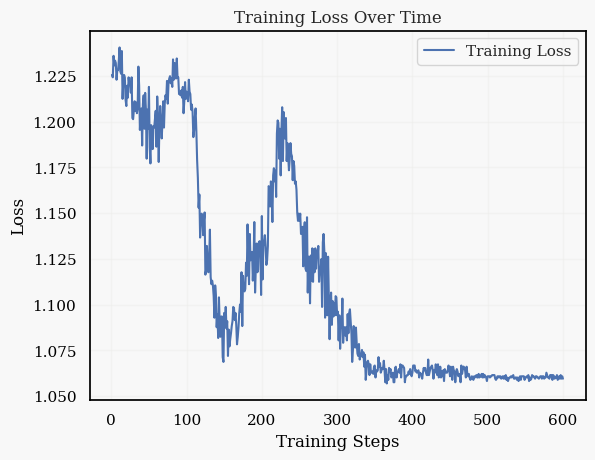

In [53]:
plt.plot(train_steps, loss_history, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Over Time')
plt.show()

## Prediction

In [54]:
model = NN().to(device)
torch.save(model.state_dict(), 'NN.pth')
model.load_state_dict(torch.load('NN.pth'))
#model.eval()

<All keys matched successfully>

In [55]:
preds = []
pred=model(pred_set)
preds.append(pred)
prediction = []
class_indices = torch.argmax(pred, dim=1)
class_mapping = {0: 'died', 1: 'euthanized', 2: 'lived'}
prediction = [class_mapping[i.item()] for i in class_indices]

In [56]:
nn_submission = pd.DataFrame({'id': sample_submission['id'], 'outcome': prediction})
nn_submission.to_csv('nn_submission.csv',index=False)

In [57]:
nn_submission.outcome.value_counts()

outcome
died          515
euthanized    252
lived          57
Name: count, dtype: int64

# 8. Baseline with Autogluon(Removed after version 26)

~~At the beginning, I'm gonna build a baseline model using an automated machine learning framework.~~

In [58]:
#!pip install autogluon

In [59]:
# from autogluon.tabular import TabularDataset, TabularPredictor

#predictor = TabularPredictor(label='outcome').fit(df_train)
#preds = predictor.predict(df_test.drop(target,axis=1))
#preds = preds.map({0:'died',1:'euthanized',2:'lived'})
#auto_submission = pd.DataFrame({'id': sample_submission['id'], 'outcome': preds})
#auto_submission.to_csv('auto_submission.csv',index=False)